# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [4]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import ujson
import tqdm

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [5]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [6]:
PATH_TO_DATA = "../data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [7]:
df_train_features.shape

(31698, 245)

In [8]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [9]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [37]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int8), array([15028, 16670]))

## <left>Наша первая модель

In [10]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [12]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 49.2 s, sys: 90.6 ms, total: 49.2 s
Wall time: 6.8 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [13]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [14]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [15]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [16]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                            index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [17]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(''.join(['../data/', submission_filename]))
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_16-30-15.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [18]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [19]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 11.8 s, sys: 1.41 s, total: 13.2 s
Wall time: 52.6 s


In [20]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [21]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [22]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строк
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [23]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [24]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

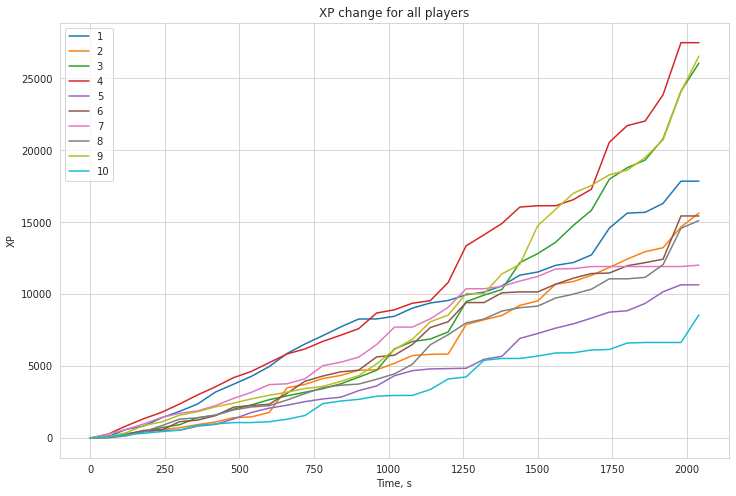

In [25]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [26]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [27]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [28]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [29]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [30]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 86.3 ms, sys: 173 ms, total: 260 ms
Wall time: 1min 12s


In [31]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# Прочитаем побольше всего

In [46]:
def add_new_features(df_features, matches_file, total_matches=31698):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, total_matches=total_matches):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        # и другие данные
        first_blood = 0
        aegis_stolen_radiant, aegis_stolen_dire = 0, 0
        aegis_denied_radiant, aegis_denied_dire = 0, 0
        radiant_roshan_kills, dire_roshan_kills = 0, 0
        barracks_kill = 0
        dire_ability_uses = 0
        rad_ability_uses = 0
        
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1
                    
            if objective["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
                barracks_kill += 1
                    
            if objective["type"] == "CHAT_MESSAGE_FIRSTBLOOD":
                if objective["player_slot"] < 6:
                    first_blood = 1
                    
            if objective["type"] == "CHAT_MESSAGE_AEGIS_STOLEN":
                if objective["player_slot"] < 6:
                    aegis_stolen_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_stolen_dire += 1
            
            if objective["type"] == "CHAT_MESSAGE_DENIED_AEGIS":
                if objective["player_slot"] < 6:
                    aegis_denied_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_denied_dire += 1
                    
                
        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        df_features.loc[match_id_hash, "radiant_roshan_kills"] = radiant_roshan_kills
        df_features.loc[match_id_hash, "dire_roshan_kills"] = dire_roshan_kills
        df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills - dire_roshan_kills
        
        df_features.loc[match_id_hash, "first_blood"] = first_blood
        df_features.loc[match_id_hash, "barracks_kill"] = barracks_kill       
        
        df_features.loc[match_id_hash, "aegis_stolen_diff"] = aegis_stolen_radiant - aegis_stolen_dire
        df_features.loc[match_id_hash, "aegis_stolen_radiant"] = aegis_stolen_radiant
        df_features.loc[match_id_hash, "aegis_stolen_dire"] = aegis_stolen_dire
            
        df_features.loc[match_id_hash, "aegis_denied_diff"] = aegis_denied_radiant - aegis_denied_dire
        df_features.loc[match_id_hash, "aegis_denied_radiant"] = aegis_denied_radiant
        df_features.loc[match_id_hash, "aegis_denied_dire"] = aegis_denied_dire
        
        for player in match["players"]:
            if player['player_slot'] > 90:
                for i in player["ability_uses"].values():
                    dire_ability_uses += i
            else:
                for i in player["ability_uses"].values():
                    rad_ability_uses += i
        
        df_features.loc[match_id_hash, "rad_ability_uses"] = rad_ability_uses
        df_features.loc[match_id_hash, "dire_ability_uses"] = dire_ability_uses 
        
        
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [47]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

## <left>Feature engineering

In [56]:
train = df_train_features_extended.copy()

<AxesSubplot:>

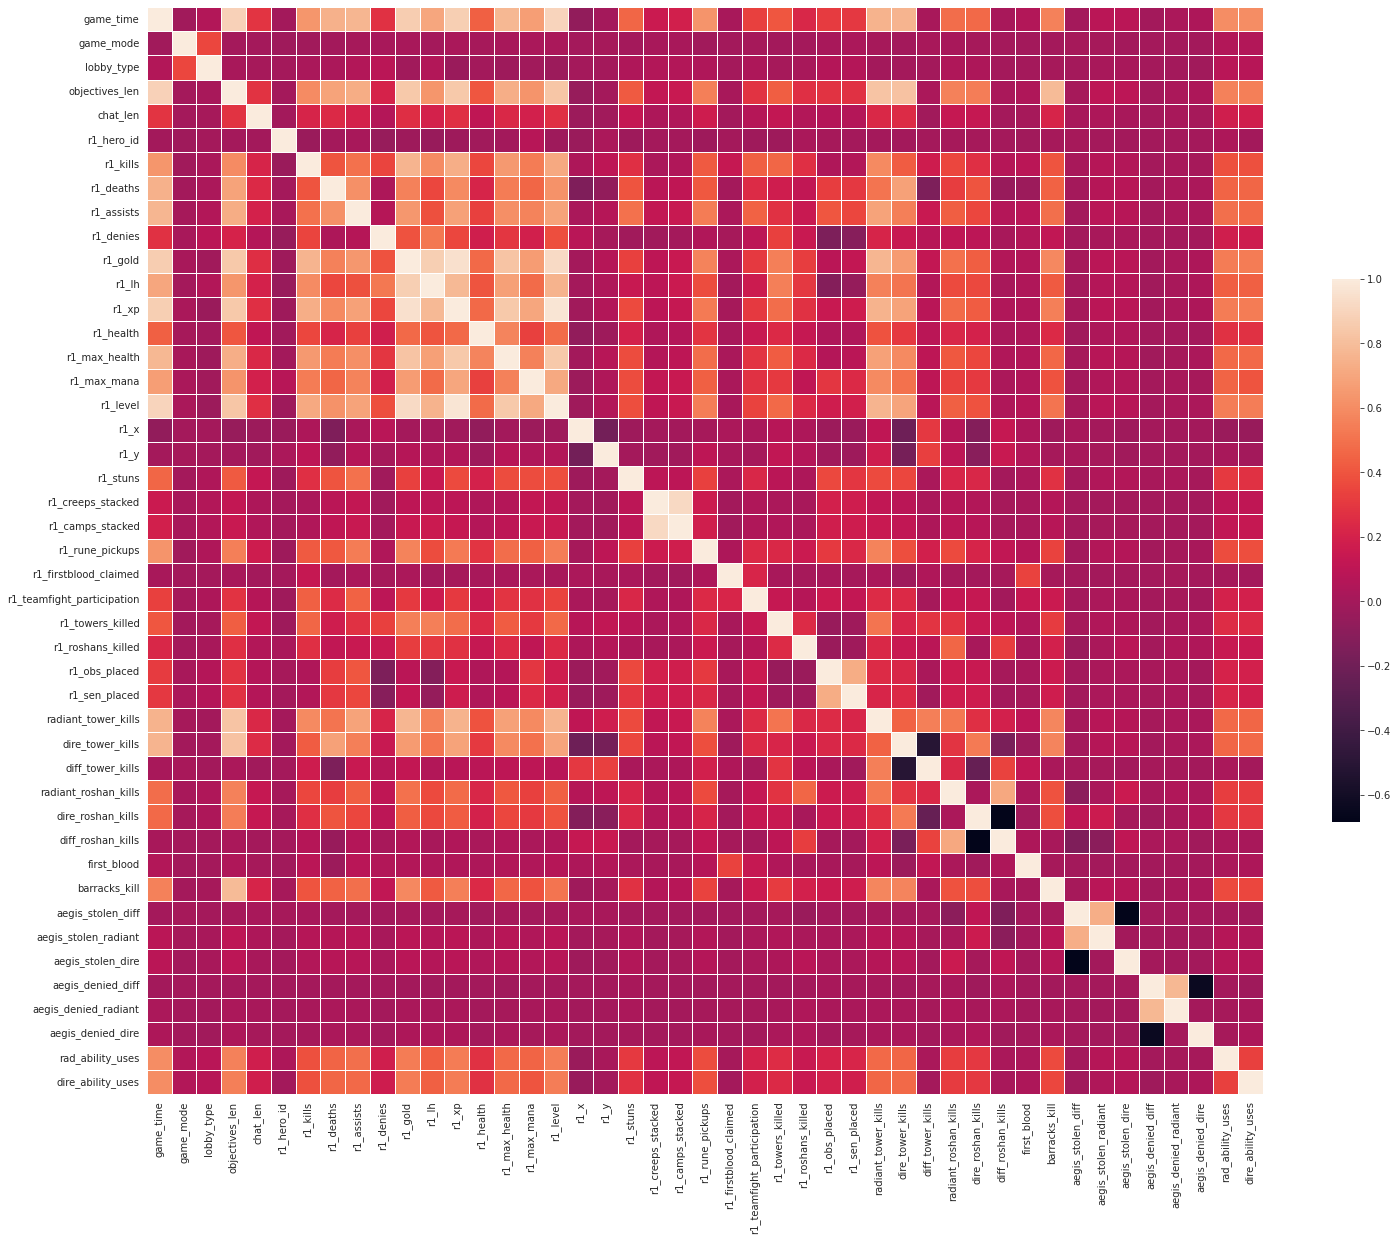

In [62]:
plt.figure(figsize=(25, 20))

sns.heatmap(train[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len', 
                                        'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 
                                        'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 
                                        'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 
                                        'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 
                                        'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed',
                                        'radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills', 'radiant_roshan_kills', 
                                        'dire_roshan_kills', 'diff_roshan_kills', 'first_blood', 'barracks_kill', 
                                        'aegis_stolen_diff', 'aegis_stolen_radiant', 'aegis_stolen_dire', 'aegis_denied_diff', 
                                        'aegis_denied_radiant', 'aegis_denied_dire', 'rad_ability_uses', 
                                        'dire_ability_uses'
                                       ]].corr(),
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

In [63]:
for i in range(1, 6):    
    train[f'd{i}_KDA'] = np.where(train[f'd{i}_deaths'] != 0, 
                                 (train[f'd{i}_kills'] + train[f'd{i}_assists']) / train[f'd{i}_deaths'],
                                  train[f'd{i}_kills'] + train[f'd{i}_assists'])
        
    train[f'r{i}_KDA'] = np.where(train[f'r{i}_deaths'] != 0, 
                                 (train[f'r{i}_kills'] + train[f'r{i}_assists']) / train[f'r{i}_deaths'],
                                  train[f'r{i}_kills'] + train[f'r{i}_assists'])
    
    train = train.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                        f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                      axis=1)

In [77]:
for i in range(1, 6):
    train = train.drop([f'd{i}_roshans_killed',
                        f'r{i}_roshans_killed'],
                      axis=1)

<AxesSubplot:>

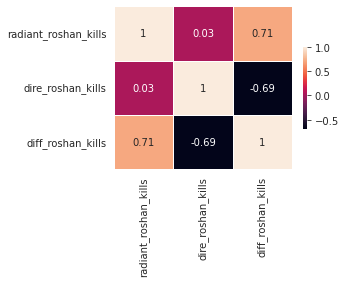

In [91]:
plt.figure(figsize=(4, 3))
sns.heatmap(train[['radiant_roshan_kills', 'dire_roshan_kills', 'diff_roshan_kills'    
]].corr(),
            linewidths=0.5, 
            annot=True,
            cbar_kws={"shrink": 0.5})

In [99]:
for i in range(1, 6):
    train = train.drop([f'd{i}_level',
                        f'r{i}_level'],
                      axis=1)

In [102]:
train['r_creeps_stacked'] = 0
train['d_creeps_stacked'] = 0
train['r_camps_stacked'] = 0
train['d_camps_stacked'] = 0


for i in range(1, 6):
    train['r_creeps_stacked'] += train[f'r{i}_creeps_stacked'] 
    train['d_creeps_stacked'] += train[f'd{i}_creeps_stacked'] 
    
    train['r_camps_stacked'] += train[f'r{i}_camps_stacked'] 
    train['d_camps_stacked'] += train[f'd{i}_camps_stacked'] 
    
    train = train.drop([f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                        f'r{i}_camps_stacked', f'd{i}_camps_stacked'],
                      axis=1)

In [111]:
train['r_lh'] = 0
train['d_lh'] = 0


for i in range(1, 6):
    train['r_lh'] += train[f'r{i}_lh'] 
    train['d_lh'] += train[f'd{i}_lh']
    
    train = train.drop([f'r{i}_lh',
                        f'd{i}_lh'],
                      axis=1)

In [118]:
train['diff_lh'] = train['r_lh'] - train['d_lh']

train = train.drop(['r_lh',
                    'd_lh'],
                    axis=1)

In [127]:
train['diff_camps_stacked'] = train['r_creeps_stacked'] - train['d_creeps_stacked']
train['diff_creeps_stacked'] = train['r_camps_stacked'] - train['d_camps_stacked']

train = train.drop(['d_creeps_stacked', 'r_creeps_stacked',
                    'd_camps_stacked', 'r_camps_stacked'],
                    axis=1)

In [129]:
train['d_gold'] = 0
train['r_gold'] = 0

for i in range(1, 6):
    train['d_gold'] += train[f'r{i}_gold'] 
    train['r_gold'] += train[f'd{i}_gold'] 
    
    train = train.drop([f'r{i}_gold',
                        f'r{i}_gold',],
                      axis=1)

In [131]:
train['diff_gold'] = train['r_gold'] - train['d_gold']

train = train.drop(['d_gold', 
                    'r_gold'],
                    axis=1)

In [143]:
train['d_xp'] = 0
train['r_xp'] = 0

for i in range(1, 6):
    train['d_xp'] += train[f'r{i}_xp'] 
    train['r_xp'] += train[f'd{i}_xp'] 
    
    train = train.drop([f'r{i}_xp',
                        f'r{i}_xp',],
                      axis=1)
    
train['diff_xp'] = train['r_xp'] - train['d_xp']

train = train.drop(['d_xp', 
                    'r_xp'],
                    axis=1)

In [ ]:
# до этого было Score: 0.82640

In [168]:
train = train.drop(['radiant_tower_kills', 'dire_tower_kills','radiant_roshan_kills', 
                    'dire_roshan_kills','aegis_stolen_radiant', 'aegis_stolen_dire',
                    'aegis_denied_radiant', 'aegis_denied_dire', 'first_blood'
                    ],
                    axis=1)

train['r_first_blood'] = 0
train['d_first_blood'] = 0

for i in range(1, 6):
    train['r_first_blood'] += train[f'r{i}_firstblood_claimed']
    train['d_first_blood'] += train[f'd{i}_firstblood_claimed']
    
    train = train.drop([f'r{i}_firstblood_claimed',
                        f'd{i}_firstblood_claimed',],
                      axis=1)

In [188]:
train['first_blood'] = train['r_first_blood'] - train['d_first_blood']

train = train.drop(['r_first_blood', 'd_first_blood'], axis=1)

In [195]:
train['r_max_mana'] = 0
train['d_max_mana'] = 0

for i in range(1, 6):
    train['r_max_mana'] += train[f'r{i}_max_mana']
    train['d_max_mana'] += train[f'd{i}_max_mana']
    
    train = train.drop([f'r{i}_max_mana',
                        f'd{i}_max_mana'],
                      axis=1)
    
train['diff_max_mana'] = train['r_max_mana'] - train['d_max_mana']

train = train.drop(['r_max_mana', 'd_max_mana'], axis=1)

<AxesSubplot:>

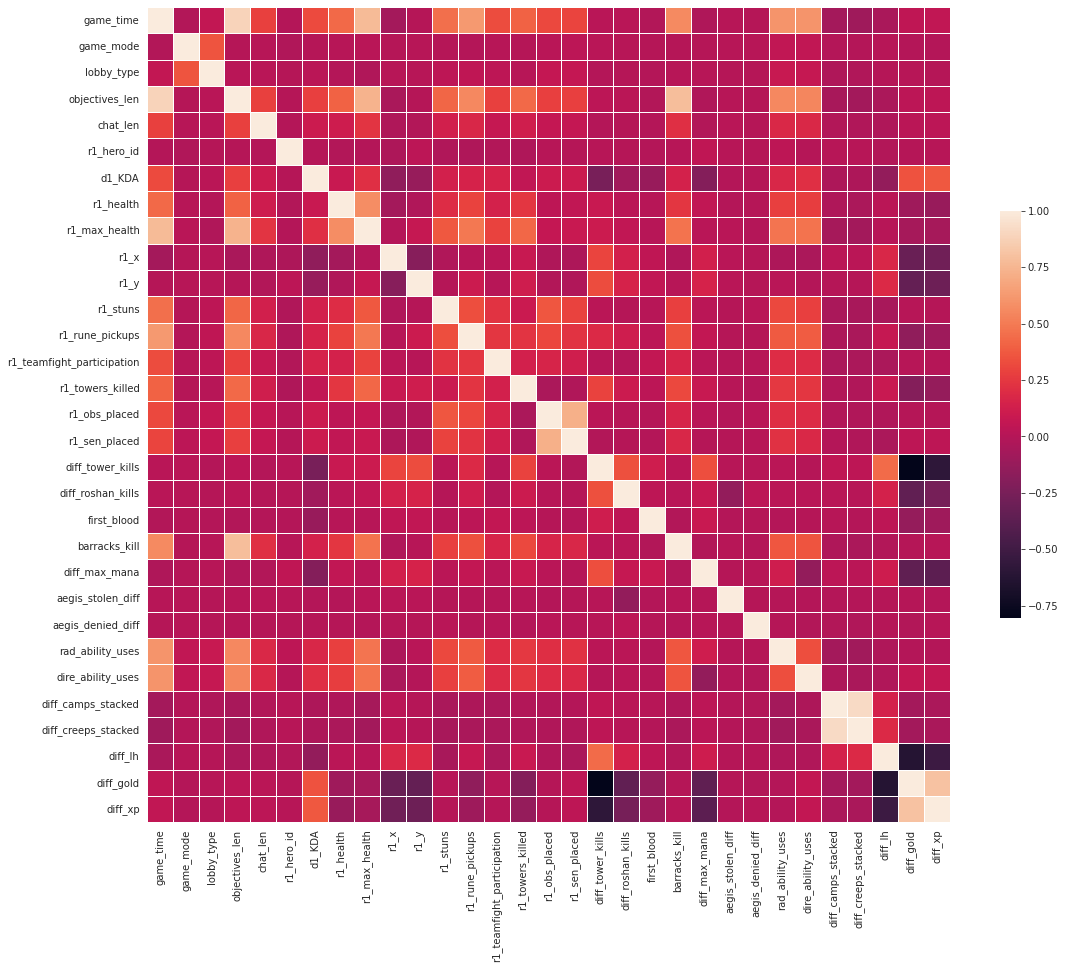

In [201]:
plt.figure(figsize=(18, 15))

sns.heatmap(train[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len', 
                   'r1_hero_id', 'd1_KDA', 'r1_health', 'r1_max_health', 
                   'r1_x', 'r1_y', 'r1_stuns', 
                   'r1_rune_pickups', 'r1_teamfight_participation', 
                   'r1_towers_killed', 'r1_obs_placed', 'r1_sen_placed',
                   'diff_tower_kills', 'diff_roshan_kills', 
                   'first_blood', 'barracks_kill', 
                   'diff_max_mana',
                   'aegis_stolen_diff', 'aegis_denied_diff', 'rad_ability_uses', 
                   'dire_ability_uses', 'diff_camps_stacked',
                   'diff_creeps_stacked', 'diff_lh', 'diff_gold', 'diff_xp'
                    ]].corr(),
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

In [202]:
print(list(train.columns))

['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len', 'r1_hero_id', 'r1_denies', 'r1_health', 'r1_max_health', 'r1_x', 'r1_y', 'r1_stuns', 'r1_rune_pickups', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_hero_id', 'r2_denies', 'r2_health', 'r2_max_health', 'r2_x', 'r2_y', 'r2_stuns', 'r2_rune_pickups', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_hero_id', 'r3_denies', 'r3_health', 'r3_max_health', 'r3_x', 'r3_y', 'r3_stuns', 'r3_rune_pickups', 'r3_teamfight_participation', 'r3_towers_killed', 'r3_obs_placed', 'r3_sen_placed', 'r4_hero_id', 'r4_denies', 'r4_health', 'r4_max_health', 'r4_x', 'r4_y', 'r4_stuns', 'r4_rune_pickups', 'r4_teamfight_participation', 'r4_towers_killed', 'r4_obs_placed', 'r4_sen_placed', 'r5_hero_id', 'r5_denies', 'r5_health', 'r5_max_health', 'r5_x', 'r5_y', 'r5_stuns', 'r5_rune_pickups', 'r5_teamfight_participation', 'r5_towers_killed', 'r5_obs_placed', 'r5_se

# Подготовим данные теста

In [48]:
df_test_features = pd.read_csv(os.path.join('../data', "test_data.csv"), 
                                            index_col="match_id_hash")

test = df_test_features.copy()

In [49]:
# Скопируем таблицу с признаками

# Добавим новые
add_new_features(test, 
                 os.path.join('../data', 
                              "test_raw_data.jsonl"),
                total_matches = 7977)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [68]:
df_test = test.copy()

In [69]:
for i in range(1, 6):    
    df_test[f'd{i}_KDA'] = np.where(df_test[f'd{i}_deaths'] != 0, 
                                    (df_test[f'd{i}_kills'] + df_test[f'd{i}_assists']) / df_test[f'd{i}_deaths'],
                                    df_test[f'd{i}_kills'] + df_test[f'd{i}_assists'])
        
    df_test[f'r{i}_KDA'] = np.where(df_test[f'r{i}_deaths'] != 0, 
                                    (df_test[f'r{i}_kills'] + df_test[f'r{i}_assists']) / df_test[f'r{i}_deaths'],
                                    df_test[f'r{i}_kills'] + df_test[f'r{i}_assists'])
    
    df_test = df_test.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                            f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                            axis=1)

In [92]:
for i in range(1, 6):
    df_test = df_test.drop([f'd{i}_roshans_killed',
                            f'r{i}_roshans_killed'],
                            axis=1)

In [105]:
for i in range(1, 6):
    df_test = df_test.drop([f'd{i}_level',
                        f'r{i}_level'],
                      axis=1)

In [106]:
df_test['r_creeps_stacked'] = 0
df_test['d_creeps_stacked'] = 0
df_test['r_camps_stacked'] = 0
df_test['d_camps_stacked'] = 0


for i in range(1, 6):
    df_test['r_creeps_stacked'] += df_test[f'r{i}_creeps_stacked'] 
    df_test['d_creeps_stacked'] += df_test[f'd{i}_creeps_stacked'] 
    
    df_test['r_camps_stacked'] += df_test[f'r{i}_camps_stacked'] 
    df_test['d_camps_stacked'] += df_test[f'd{i}_camps_stacked'] 
    
    df_test = df_test.drop([f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                        f'r{i}_camps_stacked', f'd{i}_camps_stacked'],
                      axis=1)

In [112]:
df_test['r_lh'] = 0
df_test['d_lh'] = 0


for i in range(1, 6):
    df_test['r_lh'] += df_test[f'r{i}_lh'] 
    df_test['d_lh'] += df_test[f'd{i}_lh']
    
    df_test = df_test.drop([f'r{i}_lh',
                        f'd{i}_lh'],
                      axis=1)

In [120]:
df_test['diff_lh'] = df_test['r_lh'] - df_test['d_lh']

df_test = df_test.drop(['r_lh',
                        'd_lh'],
                        axis=1)

In [134]:
df_test['diff_camps_stacked'] = df_test['r_creeps_stacked'] - df_test['d_creeps_stacked']
df_test['diff_creeps_stacked'] = df_test['r_camps_stacked'] - df_test['d_camps_stacked']

df_test = df_test.drop(['d_creeps_stacked', 'r_creeps_stacked',
                    'd_camps_stacked', 'r_camps_stacked'],
                    axis=1)

In [135]:
df_test['d_gold'] = 0
df_test['r_gold'] = 0

for i in range(1, 6):
    df_test['d_gold'] += df_test[f'r{i}_gold'] 
    df_test['r_gold'] += df_test[f'd{i}_gold'] 
    
    df_test = df_test.drop([f'r{i}_gold',
                        f'r{i}_gold',],
                      axis=1)

In [136]:
df_test['diff_gold'] = df_test['r_gold'] - df_test['d_gold']

df_test = df_test.drop(['d_gold', 
                    'r_gold'],
                    axis=1)

In [146]:
df_test['d_xp'] = 0
df_test['r_xp'] = 0

for i in range(1, 6):
    df_test['d_xp'] += df_test[f'r{i}_xp'] 
    df_test['r_xp'] += df_test[f'd{i}_xp'] 
    
    df_test = df_test.drop([f'r{i}_xp',
                        f'r{i}_xp',],
                      axis=1)
    
df_test['diff_xp'] = df_test['r_xp'] - df_test['d_xp']

df_test = df_test.drop(['d_xp', 
                    'r_xp'],
                    axis=1)

In [ ]:
# 8.2

In [ ]:
#df_test = df_test.drop(['radiant_tower_kills', 'dire_tower_kills','radiant_roshan_kills', 
#                       'dire_roshan_kills','aegis_stolen_radiant', 'aegis_stolen_dire',
#                        'aegis_denied_radiant', 'aegis_denied_dire', 'first_blood'],
#                    axis=1)

In [180]:
df_test = df_test.drop(['first_blood'], axis=1)

In [181]:
df_test['r_first_blood'] = 0
df_test['d_first_blood'] = 0

for i in range(1, 6):
    df_test['r_first_blood'] += df_test[f'r{i}_firstblood_claimed']
    df_test['d_first_blood'] += df_test[f'd{i}_firstblood_claimed']
    
    df_test = df_test.drop([f'r{i}_firstblood_claimed',
                        f'd{i}_firstblood_claimed',],
                      axis=1)

In [192]:
df_test['first_blood'] = df_test['r_first_blood'] - df_test['d_first_blood']

df_test = df_test.drop(['r_first_blood', 'd_first_blood'], axis=1)

In [203]:
df_test['r_max_mana'] = 0
df_test['d_max_mana'] = 0

for i in range(1, 6):
    df_test['r_max_mana'] += df_test[f'r{i}_max_mana']
    df_test['d_max_mana'] += df_test[f'd{i}_max_mana']
    
    df_test = df_test.drop([f'r{i}_max_mana',
                        f'd{i}_max_mana'],
                      axis=1)
    
df_test['diff_max_mana'] = df_test['r_max_mana'] - df_test['d_max_mana']

df_test = df_test.drop(['r_max_mana', 'd_max_mana'], axis=1)

# Тест получившегося

In [204]:
%%time

X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7778841417472704
CPU times: user 12.4 s, sys: 1.58 s, total: 14 s
Wall time: 41.5 s


In [205]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [206]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.7780016111389627
Accuracy score (p > 0.5) на отложенной части: 0.6982124079915878


# Подготовим посылку

In [207]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(train, y)

y_test_pred = rf_model.predict_proba(df_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_20-00-36.csv


# GS